Sandbox to develop `tools.py` functions
=======================================

**Key notes:**
* `tools.py` includes all non-TauDEM functionality.
* While `pathlib` has advnatages over `os.path`, the latter matches the syntax of `fsspec` and will better facilitate connection to remote datasets vs local without as much refactoring. Therefore it makes sense to use the `os.PathLike` protocol as the non xarray datatype for a Raster input.

## Import libraries and set path variables
**TO-DO:** For now we are accepting `str` type raster inputs, which are output by `os.path.join`. That said, ideally we should be restricting inputs more by leveraging the `os.PathLike` type. Yet to have a `os.PathLike` object we first need to use `pathlib.Path(string_path)`. **For now we can let functions accept strings directly, but in the future we may want to verify that a string is pathlike before allowing it to be passed into the function (i.e., some decorator or utility function).**

In [1]:
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import numpy as np
from pathlib import Path
from typing import Union
import os

In [2]:
# set the cutom Raster type for type hints
Raster: Union[xr.DataArray, os.PathLike, str]

In [464]:
# get all necessary paths for in/out data
in_data_dir = Path(os.path.join(os.path.dirname(str(os.getcwd())), 'in_data'))
print(f'Variable in_data_dir accesses {in_data_dir}')
out_data_dir = Path(os.path.join(os.path.dirname(str(os.getcwd())), 'out_data'))
print(f'Variable in_data_dir accesses {out_data_dir}')

# make the directories if they don't exist
for d in [in_data_dir, out_data_dir]:
    if not os.path.exists(d):
        os.makedirs(d)

Variable in_data_dir accesses C:\Users\xrnogueira\Documents\FCPGtools\examples\in_data
Variable in_data_dir accesses C:\Users\xrnogueira\Documents\FCPGtools\examples\out_data


## Import existing test data into `xr.DataArray` objects using `rioxarray`

**Notes:**
* We handle spatial reference using [rasterio's Coordinate Reference Systems (crs) module](https://rasterio.readthedocs.io/en/latest/api/rasterio.crs.html). 
* The current handling of CRS is done using the PROJ4 string representation (as opposed to WKT2 or EPSG). Here are the pros/cons based on [this article](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/spatial-data-vector-shapefiles/epsg-proj4-coordinate-reference-system-formats-python/):
    * PROJ4 is an older format that libraries are moving away from.
    * WKT is maintained by the Open Geospatial Consortium and is recognized in ESRI + ENVI projects. Also the text output is more readable. Additionally in the test FDR rasters the `DataArray['spatial_ref'].crs_wkt` prints out a WKT.
    * Finally EPSG are short codes that are still quite popular and browsable on [spatialrefernce.org](spatialrefernce.org). A big con is that when trying to use `rio.crs.to_epsg()` None is returned as under the hood rasterio tried to find the best match which isn't always possible.
    * **In conclusion I think we should switch from PROJ4 -> WKT!**
    * **Important:** `intake-stac` stored CRS as EPSG, so we should support conversion into WKT strings.

**Note:** We should have a utility function that verifies that things are path like!

In [4]:
# get tif data paths
us_fdr_tif = Path(os.path.join(in_data_dir, 'validation_upstream_fdr.tif'))
ds_fdr_tif = Path(os.path.join(in_data_dir, 'validation_downstream_fdr.tif'))
landcover_tif = Path(os.path.join(in_data_dir, 'NALCMS_2015.tif'))
precip_tif = Path(os.path.join(in_data_dir, 'validation_daymet_an_P_2017.tif'))

# get upstream basin shapefile path
us_basin_shp_path = Path(os.path.join(in_data_dir, 'upstream_wbd.shp'))

In [5]:
# test to see if these count as "PathLike" objects
print(isinstance(us_fdr_tif, os.PathLike))
print(isinstance('evil string trying to break your stuff', os.PathLike))

True
False


# `examples/test_notebook.ipynb` steps

## Import data into xarray via `rioxarray` (and `.shp` -> `gpd.GeoDataFrame`)

**Variables:**
* `us_fdr` = 8-D upstream basin Flow Direction Raster (with nan values outside of basin) (type=`xr.DataArray`).
* `ds_fdr` = 8-D downstream Flow Direction Raster (with nan values outside of basin) (type=`xr.DataArray`).
* `landcover` = categorical land cover raster (type=`xr.DataArray`).
* `precip` = coarse resolution precipitaion raster (type=`xr.DataArray`).
* `us_basin_shp` = a two row shapefile with each row representing a HUC12 basin (type=`gpd.GeoDataFrame`).

**TODO:**
* Test `rio.open_rasterio` with `.nc`.

In [6]:
%%time
# FDR rasters
us_fdr = rio.open_rasterio(us_fdr_tif)
ds_fdr = rio.open_rasterio(ds_fdr_tif)

# parameter grids
landcover = rio.open_rasterio(landcover_tif)
precip = rio.open_rasterio(precip_tif)

CPU times: total: 1 s
Wall time: 1.12 s


### Assess raster characteristics

In [7]:
precip

<xarray.DataArray (band: 1, y: 31, x: 31)>
array([[[190., 186., ..., 134., 136.],
        [184., 186., ..., 133., 134.],
        ...,
        [174., 171., ..., 201., 198.],
        [180., 181., ..., 203., 202.]]], dtype=float32)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -1.002e+06 -1.001e+06 ... -9.732e+05 -9.722e+05
  * y            (y) float64 -5.12e+05 -5.13e+05 ... -5.41e+05 -5.42e+05
    spatial_ref  int32 0
Attributes:
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1272.332104144987
    STATISTICS_MAXIMUM:      265
    STATISTICS_MEAN:         170.58792924037
    STATISTICS_MINIMUM:      116
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       35.669764565315
    _FillValue:              -999.0
    scale_factor:            1.0
    add_offset:              0.0

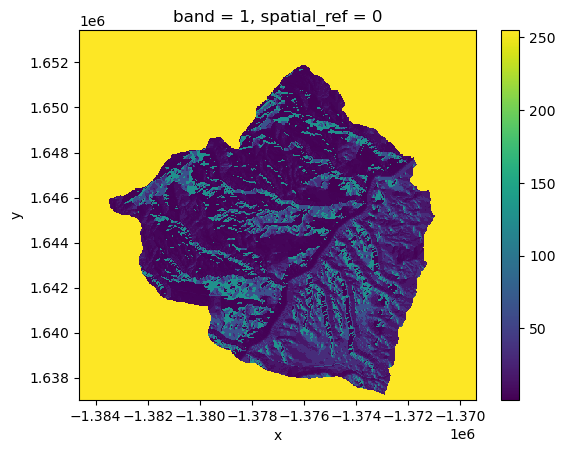

In [8]:
ds_fdr.plot()

### Assess basin shapefile characteristics

In [9]:
us_basin_shp_path.suffix 

'.shp'

In [10]:
us_basin_shp = gpd.read_file(us_basin_shp_path)
us_basin_shp.head(n=5)

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,NonContrib,NonContr_1,AreaSqKm,...,GNIS_ID,Name,States,HUC12,HUType,HUMod,ToHUC,Shape_Leng,Shape_Area,geometry
0,2685,{AAAE4745-7F69-4249-9EE6-61A0FDD375D2},{2E2678AC-0C9D-49CB-806B-540A9302D247},None,None,None,2013-01-18,0.0,0.0,133.04,...,0,Honey Draw-Colorado River,AZ,140700061105,S,DM,150100010303,0.805006,0.013444,"POLYGON ((-111.45208 36.90750, -111.45209 36.9..."
1,2737,{6ECBF3AC-20C7-4EA3-AF3A-F8DB61EF2BBB},{AEC557FF-82D8-4F4D-BF0D-2BF431714390},None,None,None,2017-10-25,0.0,0.0,90.55,...,0,Johnson Point-Paria River,"AZ,UT",140700070706,S,NM,150100010303,0.612730,0.009157,"POLYGON ((-111.69386 37.00586, -111.69386 37.0..."


<AxesSubplot:>

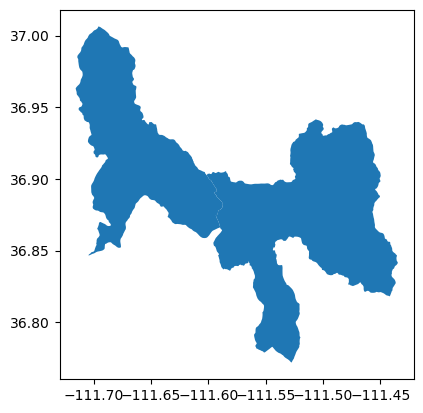

In [11]:
us_basin_shp.plot()

## Convert coordinate systems
**Note:** Here we want to be able to get the CRS in the WKT format for any `gpd.GeoDataFrame` or `xr.DataArray`, and use it to convert others.

### Find a shapefile or raster's CRS

In [12]:
# use geopandas to get the WKT for a shapefile
print(f'Basin shapefile CRS: {us_basin_shp.crs.to_wkt()}\n')

# use rioxarray to get the WKT for a DataArray
print(f'US FDR raster CRS: {us_fdr.rio.crs.to_wkt()}\n')
print(f'DS FDR raster CRS: {ds_fdr.rio.crs.to_wkt()}\n')
print(f'Landcover raster CRS: {landcover.rio.crs.to_wkt()}\n')
print(f'Precipitation raster CRS: {precip.rio.crs.to_wkt()}\n')

Basin shapefile CRS: GEOGCRS["NAD83",DATUM["North American Datum 1983",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Geodesy."],AREA["North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New Y

### Reproject a raster's CRS
**Supported options:**
* Reproject to an arbitrary WKT string.
* Reproject to match another DataArray.

**NOTE:** 
* `rioxarray` does not like overwriting! Is there a way around this or will we need to verify that the path does not exist?

In [13]:
%%time
test_path = r'C:\Users\xrnogueira\Downloads\testing2.tif'
out_test = reproject(us_fdr, precip, out_path=test_path)

NameError: name 'reproject' is not defined

In [14]:
testing = rio.open_rasterio(test_path)
out_test.plot()

NameError: name 'out_test' is not defined

### Convert a shapefile's CRS

In [ ]:
us_basin_shp.to_crs(us_fdr.rio.crs.to_wkt())

### Explore Coordinate Reference Systems

In [ ]:
# testing CRS stuff
us_fdr = rio.open_rasterio(us_fdr_tif, masked=True)
proj4 = us_fdr.rio.crs.to_proj4()
epsg = us_fdr.rio.crs.to_epsg()
wkt = us_fdr.rio.crs.to_wkt()  # NOTE: this is likely more elegent -> us_fdr['spatial_ref'].crs_wkt

for proj in {'PROJ4': proj4, 'EPSG': epsg, 'WKT2': wkt}.items():
    print(f'{proj[0]}: ' + str(proj[-1]) + '\n')

In [ ]:
print(f'Encoded nodata value in us_fdr: {us_fdr.rio.encoded_nodata}')

In [ ]:
%matplotlib widget
us_fdr.plot()

### Test CRS conversions in xarray

In [ ]:
# convert the DataArray EPSG to a WKT code
epsg = us_fdr.rio.crs.to_epsg()
wkt = us_fdr.rio.crs.from_epsg(epsg).to_wkt()
print(epsg)
print(wkt)

In [ ]:
# write the wkt to the spatial_ref
us_fdr.rio.write_crs(wkt, inplace=True)

## Resampling a raster

In [ ]:
from rasterio.enums import Resampling

In [ ]:
out_raster = precip.rio.reproject(precip.rio.crs,
                                            shape=(us_fdr.rio.height, us_fdr.rio.width),
                                            resampling=getattr(Resampling, 'bilinear'))

In [ ]:
precip.plot()

In [ ]:
out_raster.plot()

## Clipping a raster

In [ ]:
# get shapefile bbox
bbox = us_basin_shp.geometry.total_bounds
print(bbox)

In [ ]:
# clip a raster using a shapefile extent
us_fdr.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3], crs=us_basin_shp.crs.to_wkt()).plot()

In [ ]:
# get raster bbox
bbox2 = list(ds_fdr.rio.bounds())

In [ ]:
# clip a raster using another rasters bbox
precip.rio.clip_box(minx=bbox2[0], miny=bbox2[1], maxx=bbox2[2], maxy=bbox2[3], crs=ds_fdr.rio.crs.to_wkt()).plot()

In [ ]:
xmin_index = precip.argmin(dim=['x', 'y'])['x'].data.item(0)
ymin_index = precip.argmin(dim=['x', 'y'])['y'].data.item(0)
print(f'xmin:{xmin_index}, ymin:{ymin_index}')

In [ ]:
min_slice = precip.isel({'x': xmin_index,
               'y': ymin_index})

In [ ]:
xmin = min_slice.x.values
ymin = min_slice.y.values
dmin = min_slice.values.item(0)
display(xmin, ymin, dmin)

## Get min/max cell coordsinats + values. Update cell values via coordindates.

In [ ]:
def get_min_cell(raster: xr.DataArray) -> list[tuple, Union[float, int]]:
    """
    Get the minimum cell coordinates + value from a single band raster.
    :param raster: (xr.DataArray) a raster as a DataArray in memory.
    :returns: (list) a list (len=2) with the min cell's coordinate tuple [0] and value [1]
        i.e., [coords:tuple, value:Union[float, int]].
    """
    xmin_index = raster.argmin(dim=['x', 'y'])['x'].data.item(0)
    ymin_index = raster.argmin(dim=['x', 'y'])['y'].data.item(0)

    min_slice = raster.isel({'x': xmin_index,
                'y': ymin_index})
    return [(min_slice.x.values.item(0), min_slice.y.values.item(0)), min_slice.values.item(0)]

In [ ]:
def get_max_cell(raster: xr.DataArray) -> list[tuple, Union[float, int]]:
    """
    Get the maximum cell coordinates + value from a raster.
    :param raster: (xr.DataArray) a raster as a DataArray in memory.
    :returns: (list) a list (len=2) with the max cell's coordinate tuple [0] and value [1]
        i.e., [coords:tuple, value:Union[float, int, np.array]].
    """
    xmax_index = raster.argmax(dim=['x', 'y'])['x'].data.item(0)
    ymax_index = raster.argmax(dim=['x', 'y'])['y'].data.item(0)

    max_slice = raster.isel({'x': xmax_index,
                'y': ymax_index})
    return [(max_slice.x.values.item(0), max_slice.y.values.item(0)), max_slice.values.item(0)]

In [ ]:
print(get_min_cell(precip))
print(get_max_cell(precip))

In [ ]:
coords = get_min_cell(us_fdr)[0]
coords

In [ ]:
us_fdr.loc[{'x': coords[0],
            'y': coords[1]}] = 9999.333

In [ ]:
us_fdr

In [ ]:
def _verify_dtype(raster: xr.DataArray, value: Union[float, int]) -> bool:
    dtype = str(raster.dtype)
    if 'float' in dtype:
        return True
    elif not isinstance(value, int):
        return False
    else:
        if 'int8' in dtype and value > 255:
            return False
        #TODO: How best to handle other int dtype? What are the value ranges.
        return True
    
def update_cell_values(in_raster: Union[xr.DataArray, str],
                       coords: tuple,
                       value: Union[float, int],
                       out_path: str = None,
                       ) -> xr.DataArray:
    """
    Update a specific raster cell's value based on it's coordindates. This is primarily used
    to add upstream accumulation values as boundary conditions before making a FAC or FCPG.
    :param in_raster: (xr.DataArray or str raster path) input raster.
    :param coords: (tuple) coordinate as (lat:float, lon:float) of the cell to be updated.
    :param value: (float or int) new value to give the cell.
    :param out_path: (str, default=None) defines a path to save the output raster.
    :returns: param:in_raster with the updated cell value as a xarray DataArray object.
    """
    out_raster = _intake_raster(in_raster)
    if _verify_dtype(out_raster, value):
        out_raster.loc[{'x': coords[0], 'y': coords[1]}] = value

        if out_path is not None:
            print('Not none')
            _save_raster(out_raster, out_path)
        return out_raster
    else:
        #TODO: Handle exceptions
        print(f'ERROR: Value {value} does not match DataArray dtype = {in_raster.dtype}')
        return in_raster

In [ ]:
update_cell_values(us_fdr, coords, 245)

### Test with different data (daymet from THREDDS)

In [465]:
daymet = xr.open_dataset('https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1855/daymet_v4_vp_monavg_pr_2019.nc')
daymet

<xarray.Dataset>
Dimensions:                  (time: 12, nv: 2, x: 364, y: 231)
Coordinates:
  * time                     (time) datetime64[ns] 2019-01-16T12:00:00 ... 20...
  * x                        (x) float32 3.446e+06 3.447e+06 ... 3.809e+06
  * y                        (y) float32 -1.765e+06 -1.766e+06 ... -1.995e+06
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    time_bnds                (time, nv) datetime64[ns] ...
    lambert_conformal_conic  int16 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:                      2019
    source:                          Daymet Software Version 4.0
    Version_software:                Daymet Software Version 4.0
    Version_data:                    Daymet Data Version 4.0
    Conventions:                     CF-1.6
    citation:                        Please see http://daymet.ornl.gov/ for c...
    references:                      Please see http://daymet.ornl.gov/ for c...
    NCO:                             netCDF Operators version 4.9.3 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

### Note: to get a layer of a DataSet as it's own dataarray

In [233]:
# getting a layer of a dataset as a DataArray
new_daymet = daymet.isel({'time': 0})['vp']
new_daymet.plot()

In [257]:
all_times = daymet['vp']
all_times

<xarray.DataArray 'vp' (time: 12, y: 231, x: 364)>
[1009008 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2019-01-16T12:00:00 ... 2019-12-16T12:00:00
  * x        (x) float32 3.446e+06 3.447e+06 3.448e+06 ... 3.808e+06 3.809e+06
  * y        (y) float32 -1.765e+06 -1.766e+06 ... -1.994e+06 -1.995e+06
    lat      (y, x) float32 19.93 19.93 19.93 19.92 ... 16.86 16.86 16.85 16.85
    lon      (y, x) float32 -67.19 -67.18 -67.17 -67.16 ... -65.0 -64.99 -64.98
Attributes:
    units:         Pa
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: mean within days time: mean over days
    long_name:     monthly average of daily average vapor pressure
    _ChunkSizes:   [  1 231 364]

In [259]:
print(all_times.dims)
all_times.squeeze().dims

('time', 'y', 'x')


('time', 'y', 'x')

In [270]:
def test_func(**kwargs):
    if kwargs:
        print('YES')
    else:
        print('NO')
test_func()

NO


In [266]:
getattr(all_times, all_times.dims[0]).values

array(['2019-01-16T12:00:00.000000000', '2019-02-15T00:00:00.000000000',
       '2019-03-16T12:00:00.000000000', '2019-04-16T00:00:00.000000000',
       '2019-05-16T12:00:00.000000000', '2019-06-16T00:00:00.000000000',
       '2019-07-16T12:00:00.000000000', '2019-08-16T12:00:00.000000000',
       '2019-09-16T00:00:00.000000000', '2019-10-16T12:00:00.000000000',
       '2019-11-16T00:00:00.000000000', '2019-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')

**WE ARE GOING TO NEED TO SEE THE DTYPE OF DIMS, WE WILL NEED TO HANDLE DIFFERENTLY IF DATETIME**

Maybe have a dictionary that maps a integer index to the non-xy coordinate.
Avoid things based on name as much as we can.

In [234]:
xmin = new_daymet.argmin(dim=['x', 'y'])['x'].data
ymin = new_daymet.argmin(dim=['x', 'y'])['y'].data
display(xmin, ymin)

array(140, dtype=int64)

array(161, dtype=int64)

In [235]:
xmin.item(0)

140

In [251]:
# use the indices to get the x/y unit values
test = new_daymet.isel({'x': xmin,
               'y': ymin}).x
test

<xarray.DataArray 'x' ()>
array(3585750., dtype=float32)
Coordinates:
    time     datetime64[ns] 2019-01-16T12:00:00
    x        float32 3.586e+06
    y        float32 -1.926e+06
    lat      float32 18.16
    lon      float32 -66.57
Attributes:
    units:          m
    long_name:      x coordinate of projection
    standard_name:  projection_x_coordinate
    _ChunkSizes:    364

In [253]:
new_daymet

<xarray.DataArray 'vp' (y: 231, x: 364)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2019-01-16T12:00:00
  * x        (x) float32 3.446e+06 3.447e+06 3.448e+06 ... 3.808e+06 3.809e+06
  * y        (y) float32 -1.765e+06 -1.766e+06 ... -1.994e+06 -1.995e+06
    lat      (y, x) float32 19.93 19.93 19.93 19.92 ... 16.86 16.86 16.85 16.85
    lon      (y, x) float32 -67.19 -67.18 -67.17 -67.16 ... -65.0 -64.99 -64.98
Attributes:
    units:         Pa
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: mean within days time: mean over days
    long_name:     monthly average of daily average vapor pressure
    _ChunkSizes:   [  1 231 364]

In [254]:
new_daymet.dims

('y', 'x')

In [252]:
test = xr.DataArray(new_daymet,
                   dims=['x', 'y'])

ValueError: conflicting sizes for dimension 'x': length 231 on the data but length 364 on coordinate 'x'

In [245]:
test

<xarray.DataArray ()>
array(3585750., dtype=float32)

In [237]:
new_daymet.min()

<xarray.DataArray 'vp' ()>
array(1400.5745, dtype=float32)
Coordinates:
    time     datetime64[ns] 2019-01-16T12:00:00

In [ ]:
us_fdr[0][xmin][ymin].values

## Make a Flow Accumulation Raster (TauDEM + `pysheds` implementations)

**TODO:** 
* Figure out what to do with the FAC boundary conditions.

**NOTES:**
* Using log scale colorbar for accumulation makes it much prettier.

### TauDEM

In [17]:
TEMP_DIR = Path(r'C:\Users\xrnogueira\Downloads')

In [23]:
str(Path(r'C:\Users\xrnogueira\Downloads'))

'C:\\Users\\xrnogueira\\Downloads'

### Pysheds
**NOTE:** 
* PySheds uses [ESRI directions](https://mattbartos.com/pysheds/flow-directions.html).
* Let's have a function to read a Grid into raster, and a raster into a grid. **This is where we can support multidimensions!**

In [179]:
#from pysheds.pgrid import Grid as Grid
from pysheds.grid import Grid as Grid
from pysheds.view import Raster, ViewFinder
#from pysheds.pview import RegularViewFinder 
#from pysheds.view import ViewFinder
from affine import Affine

In [180]:
us_fdr.rio.write_transform(inplace=True)

us_fdr.rio.transform()
array = us_fdr.data.squeeze()
array.shape

(1039, 998)

In [360]:
%matplotlib widget
np.unique(landcover.values)

array([ 1,  7,  8,  9, 10, 14, 15, 16, 17, 18], dtype=int8)

In [450]:
def _make_new_nodata(array: xr.DataArray) -> xr.DataArray:
    #TODO: Figure out best way to deal with this
    return (array.data.squeeze().astype('int16'), 0)

def _xarray_to_pysheds(array: xr.DataArray) -> dict:
    """
    Converts a three dimension (i.e. value = f(x, y)) xr.DataArray into a pysheds Grid.
    """
    array.rio.write_transform
    affine = array.rio.transform()
    
    # nodata must be defined for pysheds
    if array.rio.nodata is None:
        array_np, nodata_val = _make_new_nodata(array)
    else:
        nodata_val = array.rio.nodata
        array_np = array.data.squeeze()  
    view = ViewFinder(shape=array_np.shape,
                      affine=affine,
                      nodata=nodata_val)
    raster_obj = Raster(array_np, view)
    
    out_dict = {'input_array': array,
                'raster': raster_obj,
                'grid': Grid().from_raster(raster_obj, affine=affine)}
    return out_dict

In [451]:
print(landcover.rio.nodata)

None


In [457]:
out_dict = _xarray_to_pysheds(landcover)

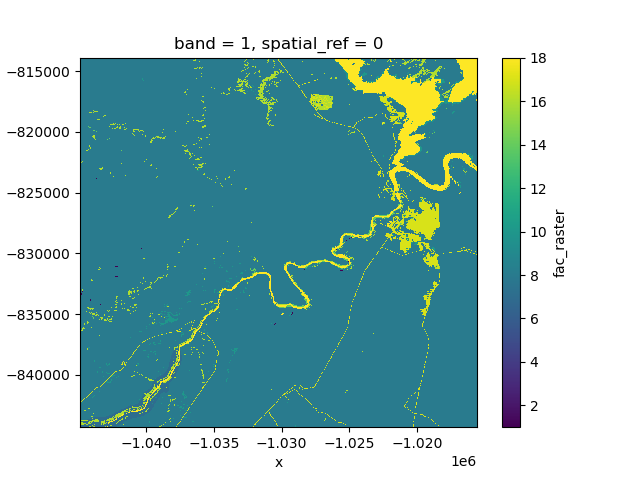

In [463]:
def _grid_to_xarray(raster, original_array) -> xr.DataArray:
    array = xr.DataArray(raster,
                  coords=original_array.squeeze().coords,
                  name='fac_raster',
                  attrs={'dtype': original_array.dtype,
                        'spatial_ref': original_array.spatial_ref})
    return array
_grid_to_xarray(out_dict['raster'], out_dict['input_array']).plot()

In [181]:
view = BaseViewFinder(shape=array.shape)

In [182]:
raster_obj.shape

(1039, 998)

In [183]:
us_fdr.data.squeeze()

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [184]:
view = ViewFinder(shape=us_fdr.data.squeeze().shape, affine=us_fdr.rio.transform())
type(view)

pysheds.sview.ViewFinder

In [190]:
raster_obj = Raster(us_fdr.data.squeeze(), view)

In [185]:
fdir = Grid(viewfinder=view)
fdir.affine

Affine(30.0, 0.0, -1384004.9999999995,
       0.0, -30.0, 1666364.9999999963)

In [192]:
fdir = Grid().from_raster(raster_obj, affine=us_fdr.rio.transform())
fdir

'affine' : Affine(30.0, 0.0, -1384004.9999999995,
       0.0, -30.0, 1666364.9999999963)
'shape' : (1039, 998)
'nodata' : 0
'crs' : <Other Coordinate Operation Transformer: longlat>
Description: PROJ-based coordinate operation
Area of Use:
- undefined
'mask' : array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [223]:
%%time
acc = xr.DataArray(fdir.accumulation(raster_obj, nodata_in=255),
                  coords=us_fdr.squeeze().coords,
                  name='fac_raster',
                  attrs={'dtype': us_fdr.dtype,
                        'spatial_ref': us_fdr.spatial_ref})

CPU times: total: 266 ms
Wall time: 250 ms


In [225]:
us_fdr.dims

('band', 'y', 'x')

In [231]:
len(us_fdr.dims)
if len(us_fdr.squeeze().dims) == 2:
    print('reduced')

reduced


In [229]:
us_fdr.squeeze().plot()

In [227]:
acc

<xarray.DataArray 'fac_raster' (y: 1039, x: 998)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes:
    dtype:        uint8
    spatial_ref:  <xarray.DataArray 'spatial_ref' ()>\narray(0)\nCoordinates:...

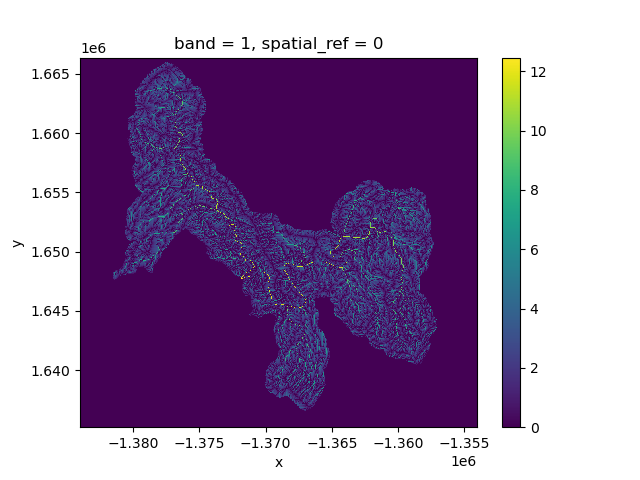

In [222]:
%matplotlib widget
np.log(acc).plot()

# Build out underlying `utilities.py` functions
**Utility functions:**
* `sample_raster()`: gets a cell value from a raster by specifying coordinates. 
* `get_min_cell()`: gets the coordinates and value of a raster's minimum cell value. 
* `get_max_cell()`: gets the coordinates and value of a raster's maximum cell value. 
* `update_cell_values()`: updates the value of a raster cell specified by coordinates.
* `get_shp_bbox()`: gets the spatial extent of a shapefile as a bounding box list.
* `get_raster_bbox()`: gets the spatial extent of a raster as a bounding box list.
* `verify_extent()`: check if coordinates are contained by a raster's extent.
* `change_nodata()`: change the nodata value of a raster.
* `minimize_extent()`: clip a raster to it's minimum rectangular extent containing all non-nodata values.
* `convert_dtype():` **COME BACK TO THIS**.

## `rioxarray` utility functions

## `xarray` alone utility functions

In [ ]:
def sample_raster(raster: xr.DataArray,
                  coords: tuple,
                  ) -> Union[float, int]:
    """
    :param raster: (xr.DataArray) a raster as a DataArray in memory.
    :param coords: (tuple) coordinate as (lat:float, lon:float) of the cell to be sampled.
    :returns: (float or int) the cell value at param:coords.
    """
    pass

def get_min_cell(raster: xr.DataArray) -> list[tuple, Union[float, int]]:
    """
    Get the minimum cell coordinates + value from a raster.
    :param raster: (xr.DataArray) a raster as a DataArray in memory.
    :returns: (list) a list (len=2) with the min cell's coordinate tuple [0] and value [1]
        i.e., [coords:tuple, value:Union[float, int]].
    """
    pass

def get_max_cell(raster: xr.DataArray) -> list[tuple, Union[float, int]]:
    """
    Get the maximum cell coordinates + value from a raster.
    :param raster: (xr.DataArray) a raster as a DataArray in memory.
    :returns: (list) a list (len=2) with the max cell's coordinate tuple [0] and value [1]
        i.e., [coords:tuple, value:Union[float, int, np.array]].
    """
    pass

def change_nodata(in_raster: Union[xr.DataArray, str],
                  nodata_value: Union[float, int],
                  out_path: str = None,
                  convert_dtype: bool = True,
                  ) -> xr.DataArray:
    """
    Update a specific raster nodata value.
    :param in_raster: (xr.DataArray or str raster path) input raster.
    :param nodata_value: (float or int) new value to give nodata cells before saving.
    :param out_path: (str, default=None) defines a path to save the output raster.
    :param convert_dtype: (bool, default=True) if param:nodata_value is non-compatible
        with in_raster's dtype, a dtype conversion is default unless False.
    :returns: param:in_raster with the updated nodata values as a xarray DataArray object.
    """
    # Note for dev: we need to understand xarray's handling of nodata values
    pass

# Build out main `tools.py` functions
**Main functions:**
* `find_cell_downstream()`
* `spatial_mask()`
* `value_mask()`
* `nodata_mask()`
* `apply_mask()`
* `binarize_categorical_rasters()`
* `find_pour_points()`
* `create_fcpg()`
* `fix_pits()`
* `fix_depressions()`
* `fix_flats()`
* `d8_fdr()`
* `clip()`
* `reproject()`
* `resample()`